In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from crop_image import *
import imutils
from imutils import contours as imcnts
import skimage.io as io
from skimage.exposure import histogram
from bubble_sheet_answer import *
from paper_extraction import *
from crop_image import *
import pickle
#from commonfunctions import *
%matplotlib inline

In [4]:
def load_models():
    loaded_svc = pickle.load(open('./Train/SVC.sav', 'rb'))
    loaded_knn = pickle.load(open('./Train/KNN.sav', 'rb'))
    loaded_rf = pickle.load(open('./Train/RF.sav', 'rb'))
    loaded_lr = pickle.load(open('./Train/LR.sav', 'rb'))

    return loaded_svc, loaded_knn, loaded_rf, loaded_lr


#####################################################################
loaded_svc, loaded_knn, loaded_rf, loaded_lr = load_models()


FileNotFoundError: [Errno 2] No such file or directory: './Train/SVC.sav'

In [5]:
def extract_the_paper_from_image_ID(image):
        paper = None
        contours, _ = cv2.findContours(image,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if (len(contours) > 0):
            contours = sorted(contours, key=cv2.contourArea, reverse=True)
            paper_contour = None
            paper = image
            for cnt in contours:
                peri = cv2.arcLength(cnt, True)
                ratio = 0.01
                approx = cv2.approxPolyDP(cnt, ratio*peri, True)
                if (len(approx) == 4 and cv2.contourArea(cnt)>0.2*image.shape[0]*image.shape[1]):
                    paper_contour = approx
                    paper = four_point_transform(image, paper_contour.reshape(4, 2))
                else:
                    break
        return paper

def classifier_algorithm (myc, median_width, image, loaded_svc, loaded_knn, loaded_rf, loaded_lr):
    ID_weights = [1,7,1,1,2,1,1,22,4,1]
    strFinalString=""
    classifiers_respond = np.zeros(10)
    
    [intX, intY, intW, intH] = cv2.boundingRect(myc)
    imgROI = image[intY:intY+intH, intX:intX+intW]
    
    if(intW>1.8*median_width):
        
        connected_images_array = []
        for count in range(round(intW/median_width)):
            croped_image = np.array(image[intY:intY+intH, intX+int(intW*(count/(round(intW/median_width)))):intX+int(intW*((count+1)/(round(intW/median_width))))])
            connected_images_array.append(croped_image)
            
        for img in connected_images_array:
            img = np.asarray(img.astype(np.uint8))
            connected_contours,_ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            connected_contours = sorted(connected_contours, key=cv2.contourArea, reverse=True)
            
            strFinalString = strFinalString + classifier_algorithm(connected_contours[0], median_width,img,loaded_svc, loaded_knn, loaded_rf, loaded_lr)
    elif(cv2.contourArea(myc)):
        imgROIResized = cv2.resize(imgROI, (28, 28), cv2.INTER_NEAREST)

        finalResized = imgROIResized.reshape((-1,1))
        
        
        #EXTRACTING FEATURES
        hog_of_img = np.asarray(extract_hog_features(imgROIResized))
        hog_of_img = hog_of_img.reshape(1,-1)
        knn_value = loaded_knn.predict(hog_of_img)
        rf_value = loaded_rf.predict(hog_of_img)
        svc_value = loaded_svc.predict(hog_of_img)
        lr_value = loaded_lr.predict(hog_of_img)
        classifiers_respond[int(knn_value)] = classifiers_respond[int(knn_value)] + ID_weights[int(knn_value)]
        classifiers_respond[int(rf_value)] = classifiers_respond[int(rf_value)] + ID_weights[int(rf_value)]
        classifiers_respond[int(svc_value)] = classifiers_respond[int(svc_value)] + ID_weights[int(svc_value)]
        classifiers_respond[int(lr_value)] = classifiers_respond[int(lr_value)] + ID_weights[int(lr_value)]
        final_value = str(np.argmax(classifiers_respond))
        
        tmpString = str(int(final_value))
        strFinalString = strFinalString + tmpString
    return strFinalString

def detect_id(img, loaded_svc, loaded_knn, loaded_rf, loaded_lr):
    #PRE-PROCESSING
    bf = cv2.bilateralFilter(img, 50, 100, 100) #to remove noise
    imgGray = cv2.cvtColor(bf, cv2.COLOR_BGR2GRAY)
    
    th= cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  cv2.THRESH_BINARY, 51, 12)
    plt.imshow(th,cmap='gray')
    #th=np.invert(th)
    #plt.imshow(th,cmap='gray')
    imgDigit = th


    strFinalString = ""
    plt.imshow(imgDigit,cmap='gray')
    imgDigit = extract_the_paper_from_image_ID(imgDigit)

    
    width_sum=[]
    cntr, h = cv2.findContours(imgDigit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(len(cntr))
    for cnt in cntr:
        [intX, intY, intW, intH] = cv2.boundingRect(cnt)
        plt.imshow(imgDigit[intY:intY+intH, intX:intX+intW],cmap='gray')
        print(intW)
        if(intW>5):
            width_sum = np.append(width_sum , [intW])

    median_width = statistics.median(width_sum)
    cntr,_=imcnts.sort_contours(cntr,method='left-to-right')
    for myc in cntr:
        [intX, intY, intW, intH] = cv2.boundingRect(myc)
        if (intW>15 and intH>15):
            strFinalString = strFinalString + classifier_algorithm(myc, median_width,imgDigit, loaded_svc, loaded_knn, loaded_rf, loaded_lr)
    return strFinalString

In [6]:
def extract_the_paper_from_image(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        adaptively_thresholded = cv2.adaptiveThreshold(gray_scale,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)
        plt.imshow(adaptively_thresholded,cmap='gray')
        contours, _ = cv2.findContours(adaptively_thresholded,
                                       cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        if (len(contours) > 0):
            contours = sorted(contours, key=cv2.contourArea, reverse=True)
            paper_contour = None
            paper = image
            for cnt in contours:
                peri = cv2.arcLength(cnt, True)
                ratio = 0.01
                approx = cv2.approxPolyDP(cnt, ratio*peri, True)
                print(len(approx),cv2.contourArea(cnt), image.shape[0]*image.shape[1])
                if (len(approx) == 4 and cv2.contourArea(cnt)>0.2*image.shape[0]*image.shape[1]):
                    paper_contour = approx
                    paper = four_point_transform(image, paper_contour.reshape(4, 2))
                else:
                    break
        return paper


4 5574579.5 7990272
4 3659331.5 7990272
4 3609606.0 7990272
8 1987100.0 7990272


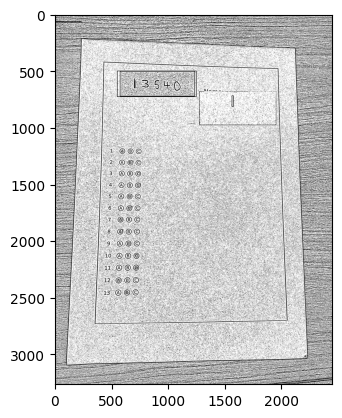

In [15]:
image= cv2.imread('testCases/withID.jpg') 
plt.imshow(image)
paper=extract_the_paper_from_image(image)
cv2.imwrite('./paper.jpg',paper)
temp=paper.copy()
#paper=extract_the_paper_from_image(paper)
bubble_size=(5,50)

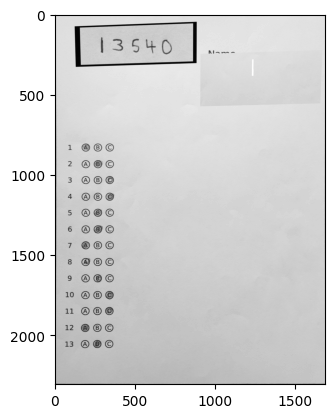

In [16]:
# Get the gray scale paper 
gray_scale_paper = cv2.cvtColor(paper,cv2.COLOR_BGR2GRAY)
cv2.imwrite('./gray.jpg',paper)
plt.imshow(gray_scale_paper,cmap='gray')

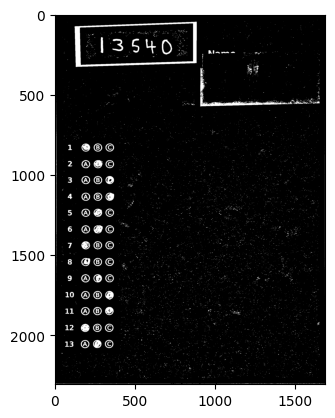

In [17]:
# Get binary paper
thresholded=cv2.adaptiveThreshold(gray_scale_paper, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV, 73, 5)
plt.figure()
plt.imshow(thresholded,cmap='gray')
# # Make Morphological Operation (Opening To Spilit Bubbles From Each Others)
# thresholded=cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, np.ones((2,2)))
# plt.figure()
# plt.imshow(thresholded,cmap='gray')
# thresholded = cv2.dilate(thresholded,np.ones((2,2)),iterations = 1)
# plt.figure()
# plt.imshow(thresholded,cmap='gray')

here


True

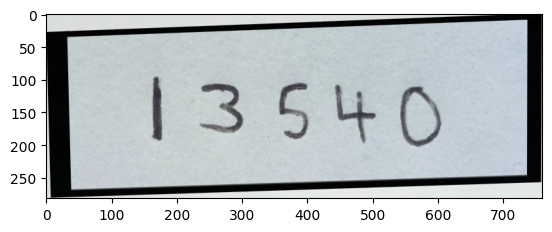

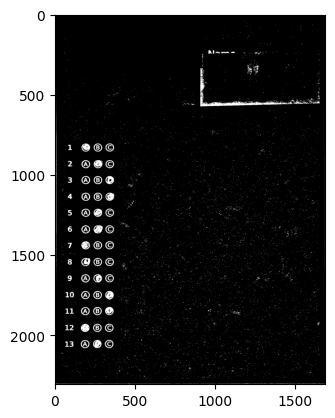

In [18]:
#extract id box from image
cntr, h = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(cntr, key=cv2.contourArea, reverse=True)
for c in cnt:
    peri = cv2.arcLength(c, True)
    ratio = 0.01
    approx = cv2.approxPolyDP(c, ratio*peri, True)
    if (len(approx) == 4):
        print('here')
        idBoxContour= c
        [intX, intY, intW, intH] = cv2.boundingRect(idBoxContour)
        idBoxImage = paper[intY:intY+intH, intX:intX+intW]
        thresholded[intY:intY+intH, intX:intX+intW] = 0
        break
plt.imshow(idBoxImage,cmap='gray')
cv2.imwrite('./readme imgs/id box.jpg',idBoxImage)
#id = detect_id(idBoxImage, loaded_svc, loaded_knn, loaded_rf, loaded_lr)
#print('id = ',id)
plt.figure()
plt.imshow(thresholded, cmap='gray')
cv2.imwrite('./readme imgs/paperwithoutbox.jpg',thresholded)

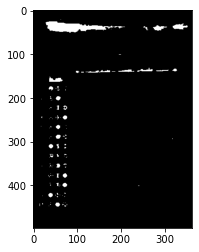

In [296]:
# eroded=cv2.dilate(thresholded,np.ones((2,2)),iterations=2)
# plt.figure()
# plt.imshow(thresholded,cmap='gray')
# eroded = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, np.ones((3,3)))
eroded=cv2.erode(thresholded,np.ones((3,3)),iterations=1)
# plt.figure()
# plt.imshow(eroded,cmap='gray')
# eroded=cv2.dilate(eroded,np.ones((2,2)),iterations=5)
plt.figure()
plt.imshow(eroded,cmap='gray')

In [297]:
#Get Average Area
areas=[]
# Get the external contours
pap_cnts,_=cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Check if there are no contours
if(len(pap_cnts)==0):
    print("No external contours found")

# Get the bubbles contours
pre_question_cnts=[]
for cnt in pap_cnts:
    (x,y,w,h)=cv2.boundingRect(cnt)
    aspect_ratio=w/h
    peri = cv2.arcLength(cnt, True)
    ratio = 0.01
    approx = cv2.approxPolyDP(cnt, ratio*peri, True)
    if(aspect_ratio>=0.8 and aspect_ratio<=1.2 and len(approx)>=4 and cv2.contourArea(cnt)>30 and cv2.contourArea(cnt)>1.5*peri):
        areas.append(cv2.contourArea(cnt))
        pre_question_cnts.append(cnt)
        print(len(approx))

# Check if there are no contours
if(len(pre_question_cnts)==0):
    print("No bubbles contours found")
print(len(pre_question_cnts),len(pap_cnts))


13
16
14
15
21
21
15
18
18
14
12
16
16
15
17
15
11
8
12
10
12
11
11
18
14
16
12
12
19
14
16
14
10
17
15
15
17
14
38 134


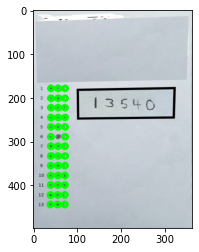

In [298]:
temp3333=paper.copy()
cv2.drawContours(temp3333,pre_question_cnts,-1,(0,255,0), 5)
plt.figure()
plt.imshow(temp3333)

In [299]:
#print(cnt_cont,sum_cont_area,sum_cont_area/cnt_cont)
bubble_area=np.median(areas)
print(bubble_area)
#print(np.median(areas))
#print(np.amin(areas))
question_cnts_copy=[]
for i,area  in enumerate(areas):
    #print(i,area,abs(area-bubble_area))
    if(abs(area-bubble_area)<=bubble_area*.3):
        question_cnts_copy.append(pre_question_cnts[i])
pre_question_cnts= question_cnts_copy      
print(len(pre_question_cnts))

99.75
38


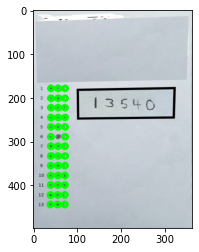

In [300]:
temp3333=paper.copy()
cv2.drawContours(temp3333,pre_question_cnts,-1,(0,255,0), 5)
plt.figure()
plt.imshow(temp3333)

In [301]:
if(len(pre_question_cnts)):
    # Sort the contours from top to bottom
    question_cnts,_=imcnts.sort_contours(pre_question_cnts,method='top-to-bottom')

    # Detect the number of choices and the number of columns
    xs_set=np.array([])
    (_,__,bubble_width,___)=cv2.boundingRect(pre_question_cnts[0])
    for cnt in question_cnts:
        (x,y,w,h)=cv2.boundingRect(cnt)
        xs_set=np.append(xs_set,x)
    xs_set=np.sort(xs_set)
    number_of_bubbles=0
    number_of_xs=len(xs_set)
    number_of_columns=1
    print(xs_set,bubble_width)
    for i in range(1,number_of_xs):
        #print(xs_set[i]-xs_set[i-1])
        if(xs_set[i]-xs_set[i-1]>=0.5*bubble_width and xs_set[i]-xs_set[i-1]<=2*bubble_width):
            number_of_bubbles+=1
        elif(xs_set[i]-xs_set[i-1]>2.5*bubble_width):
            number_of_columns+=1
    number_of_bubbles+=number_of_columns
    number_of_choices=number_of_bubbles//number_of_columns
    print(number_of_columns,number_of_choices,number_of_bubbles)

[34. 34. 34. 34. 34. 35. 35. 35. 35. 35. 35. 35. 35. 50. 50. 50. 51. 51.
 51. 51. 51. 51. 51. 51. 51. 66. 66. 66. 67. 67. 67. 67. 67. 67. 67. 67.
 67. 67.] 13
1 3 3


In [302]:
colors=[(255,0,0)
,(0,255,0)
,(0,0,255)
,(255,0,0)
,(0,255,0)
,(0,0,255)
,(0,255,0)
,(255,0,0)
,(255,255,192)
,(225,255,128)
,(128,0,0)
,(128,128,0)
,(0,128,0)
,(128,0,128)
,(0,128,128)
,(0,0,128),
       (255,215,0)]

In [303]:
def detect_number_of_contours(cnts):
    (_,prev_y,___,bubble_height)=cv2.boundingRect(cnts[0])
    #print("height",bubble_height)
    for i,cnt in enumerate(cnts):
        (x,y,w,h)=cv2.boundingRect(cnt)
        #print("y",y)
        if(abs(y-prev_y)>0.3*bubble_height):
            #print("abs",abs(y-prev_y))
            return 1
    return 0

In [304]:
number_of_questions=len(pre_question_cnts)//number_of_choices
cut_row=10000000
is_cut=0
if(len(pre_question_cnts)):
    qs=0
    # Get student answers
    answers=[]
    temp_number_of_columns=number_of_columns
    # Iterate over each row
    i=0
    while (i<len(question_cnts)):
        # detect number of contours in row
        if(not is_cut):
            is_cut=detect_number_of_contours(question_cnts[i:i+number_of_columns*number_of_choices])
            if(is_cut):
                temp_number_of_columns-=1
            cut_row=i
            print("its ok",temp_number_of_columns,cut_row)
            
        number_of_conts=temp_number_of_columns*number_of_choices
        print("conts",number_of_conts)

        # Get all bubbles of the current row which has (number_of_columns) questions
        curr_row_cnts,_=imcnts.sort_contours(question_cnts[i:i+number_of_conts])
        #print(curr_row_cnts)
        
        # Iterate over each question
        for k in np.arange(0,len(curr_row_cnts),number_of_choices):

            # Current Question answers
            curr_ques_cnts=curr_row_cnts[k:k+number_of_choices]
            color1=colors[qs%len(colors)]
            qs=qs+1
            cv2.drawContours(temp,curr_ques_cnts,-1,color1, 5)

            mask_ones=[]
            bubbles=[]
            for j,c in enumerate(curr_ques_cnts):

                # Get the maximum shaded bubble
                mask = np.zeros(thresholded.shape, dtype="uint8")
                cv2.drawContours(mask, [c], -1, 255, -1)
                mask_ones.append(cv2.countNonZero(mask))
                mask= cv2.bitwise_and(eroded, mask)
                total= cv2.countNonZero(mask)
                bubbles.append(total)
            mask_mean=np.mean(mask_ones)
            bubbles=np.array(bubbles)/mask_mean
            bubbled=np.argmax(bubbles)
            total=np.amax(bubbles)
            count_chosen=0
            if(total>0.7):
                count_chosen=((total-bubbles)<=0.3).sum()
            else:
                count_chosen=((total-bubbles)<=0.15).sum()
            final_ans=(ord('X')-ord('A')) if(count_chosen!=1) else bubbled
            answers.append(chr(final_ans+ord('A')))
        print("PCCCCCCCCCCCCC",i,temp_number_of_columns)
        i+=(temp_number_of_columns*number_of_choices)
    print(answers,len(answers))
    

its ok 1 0
conts 3
PCCCCCCCCCCCCC 0 1
its ok 1 3
conts 3
PCCCCCCCCCCCCC 3 1
its ok 1 6
conts 3
PCCCCCCCCCCCCC 6 1
its ok 1 9
conts 3
PCCCCCCCCCCCCC 9 1
its ok 1 12
conts 3
PCCCCCCCCCCCCC 12 1
its ok 0 15
conts 0


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
plt.figure()
plt.imshow(temp)
# paper=extract_the_paper_from_image(image)
#paper=extract_the_paper_from_image(paper)

In [ ]:
number_of_rows=0
x_sorted_conts,_=imcnts.sort_contours(question_cnts)
(prev_x,_,bubble_width,__)=cv2.boundingRect(x_sorted_conts[0])
for i,cnt in enumerate(x_sorted_conts):
    (x,y,w,h)=cv2.boundingRect(cnt)
    #print("y",y)
#     print(prev_x,x,bubble_width,i)
    if(abs(prev_x-x)>=2.5*bubble_width):
        number_of_rows=i
        break
    prev_x=x
print(number_of_rows//number_of_choices)
number_of_rows=number_of_rows//number_of_choices
number_of_rows=number_of_questions if not number_of_rows else number_of_rows

In [ ]:
print(cut_row,cut_row//(number_of_choices*number_of_columns))
cut_row=cut_row//(number_of_choices*number_of_columns)

In [ ]:
curr_cnt=0
final_answers=[0] * number_of_questions
for i in range(0,number_of_rows):
    for j in range(0,number_of_columns-int(i>=cut_row and cut_row!=number_of_rows-1)):
        print(curr_cnt+1,j*number_of_rows+i+1,int(i>=cut_row and cut_row!=number_of_rows-1))
        final_answers[j*number_of_rows+i]=answers[curr_cnt]
        curr_cnt+=1
print(final_answers)

In [ ]:
for key,val in enumerate(final_answers):
    print(key+1,val)

In [ ]:
answers[39]

In [ ]:
len(answers)